## Import and eval functions

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, h5py, gc, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
import concurrent.futures as cf
from pathlib import Path
from torch.utils.data import DataLoader

REPO_ROOT = "../"
proj = Path(REPO_ROOT).resolve()

# allow: import ADCNN.*
sys.path.insert(0, str(proj))

# allow: import utils.*  (where utils == ADCNN/utils)
sys.path.insert(0, str(proj / "ADCNN"))

import exp_utils.postprocess as postprocess
from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full
import ADCNN.evals.basic_evals as evals
import ADCNN.evals.threshold_scan as threshold_scan

test_h5 = "../DATA/test.h5"
test_csv = "../DATA/test.csv"
MODEL_CKPT = "../checkpoints/Best/ckpt_best.pt"
SAVE_PATH = "../checkpoints/Experiments/"

In [2]:
def calculate_model_metrics (catalog, predictions, ground_truth, thr_points=100, stack_fp=None):
    catalog = catalog.copy()
    threshold_df = threshold_scan.scan_thresholds(catalog=catalog, predictions=predictions, ground_truth=ground_truth, stack_fp=stack_fp, n_points=thr_points)
    threshold_scan.plot_fscore(threshold_df["thr"], pix_f1=threshold_df.get("pix_f1"), pix_f2=threshold_df.get("pix_f2"),
                               obj_f1=threshold_df.get("obj_f1"), obj_f2=threshold_df.get("obj_f2"), title="Pixelwise vs Objectwise F-scores")
    threshold_scan.plot_roc(threshold_scan.compute_roc(threshold_df["pix_tp"], threshold_df["pix_fp"], threshold_df["pix_tn"], threshold_df["pix_fn"]))
    threshold_scan.plot_froc(threshold_scan.compute_froc(thr=threshold_df["thr"], obj_tp=threshold_df["obj_tp"], obj_fp=threshold_df["obj_fp"], obj_fn=threshold_df["obj_fn"], n_images=50),
                             title="FROC (objectwise)")
    best_threshold = threshold_df["thr"][threshold_df["obj_f2"].argmax()]
    _,_,catalog = evals.confusion_matrix(catalog=catalog, ground_truth= ground_truth,predictions=predictions, stack_fp=stack_fp, threshold=best_threshold, verbose=True)
    _ = evals.plot_detect_hist(catalog, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=" + str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "trail_length", bins=12, title="Detections vs trail length threshold="+ str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "SNR", bins=10, title="Detections vs SNR threshold="+ str(round(best_threshold, 3)), xlim=[0, 10], density=True)
    plt.show()
    return catalog

In [3]:
ds_te = H5TiledDataset(test_h5,  tile=128, k_sigma=5.0)

test_loader = DataLoader(
    ds_te,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=None,
)

test_catalog = pd.read_csv(test_csv)
with h5py.File(test_h5, "r") as _f:
    gt_test = _f["masks"][:].astype(np.uint8)
    stack_fp = _f["real_labels"][:].astype(np.uint16)
print("Test tiles:", len(ds_te))

Test tiles: 51200


## LSST stack

In [4]:
def get_stack_metrics (catalog, fp_mask):
    tp = (catalog["stack_detection"]==True).sum()
    fn = (catalog["stack_detection"]==False).sum()
    fp = fp_mask.max(axis=(1, 2)).sum()
    return  {"TP": tp, "FP": fp, "FN": fn, "TN": pd.NA}

evals.print_confusion_matrix(get_stack_metrics (test_catalog, stack_fp), title="Object-wise Confusion Matrix")

Object-wise Confusion Matrix
F1 Score: 0.0072, F2 Score: 0.0175
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>              133679
Actual Positive                 516                 484



## Baseline

In [5]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(test_h5, test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
del (model_baseline)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_baseline.shape)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


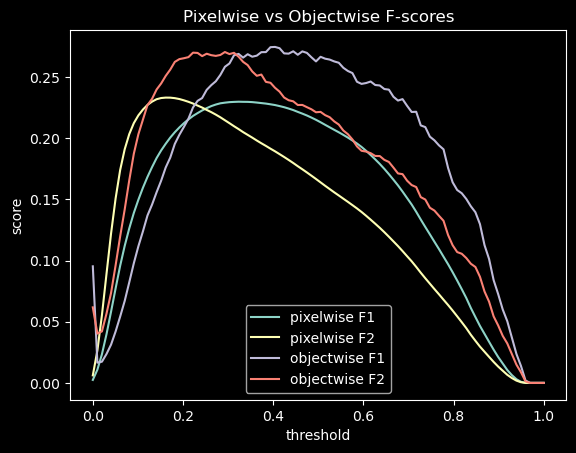

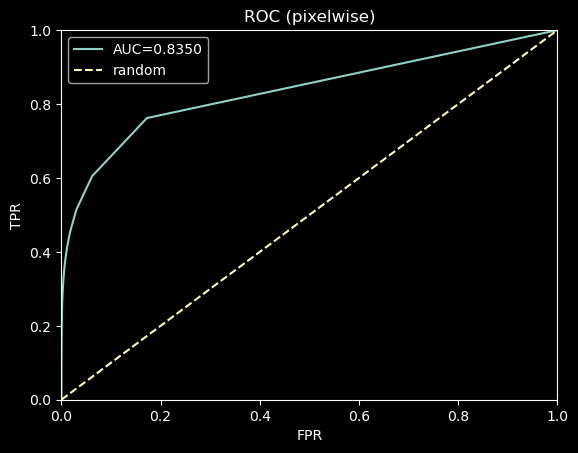

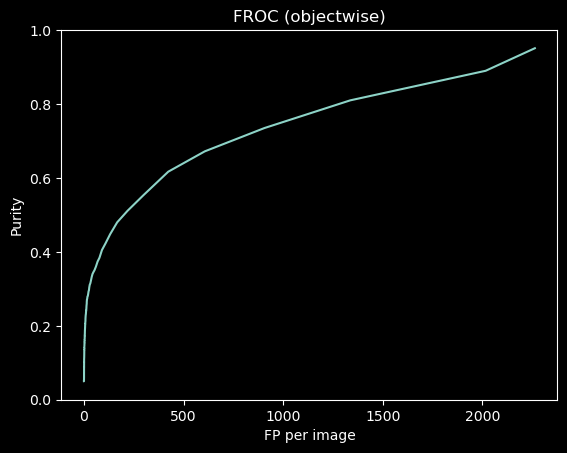

Pixel-wise Confusion Matrix
F1 Score: 0.2289, F2 Score: 0.2145
                 Predicted Negative  Predicted Positive
Actual Negative           812795451              597155
Actual Positive              799982              207412

Object-wise Confusion Matrix
F1 Score: 0.2616, F2 Score: 0.2718
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 854
Actual Positive                 721                 279



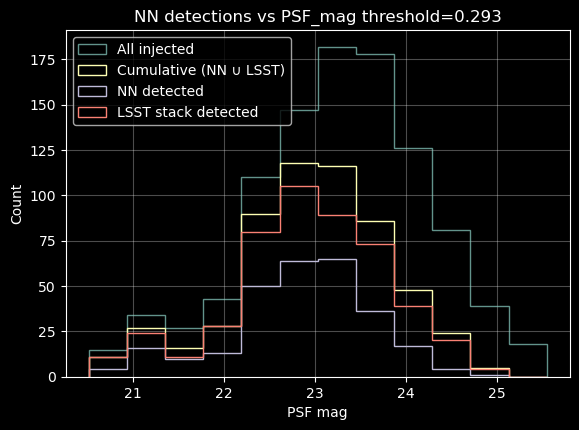

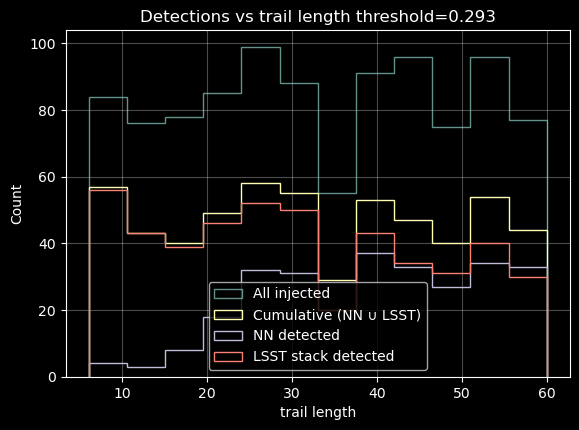

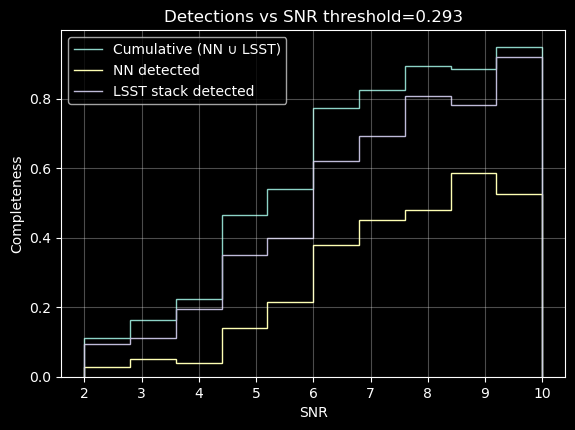

In [6]:
cat_baseline = calculate_model_metrics(test_catalog, p_baseline, gt_test, stack_fp=stack_fp)

## Idea 1

Oversampling LSST-missed examples

In [7]:
model_1 = load_model(SAVE_PATH+"Last/idea1.pt")
p_1 = predict_tiles_to_full(test_h5, test_loader, model_1, tile=128)
model_1.to('cpu')
del (model_1)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_1.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea1.pt
Predictions shape: (50, 4000, 4072)


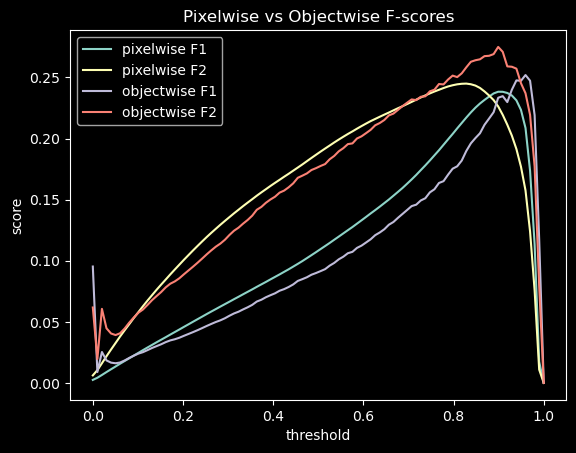

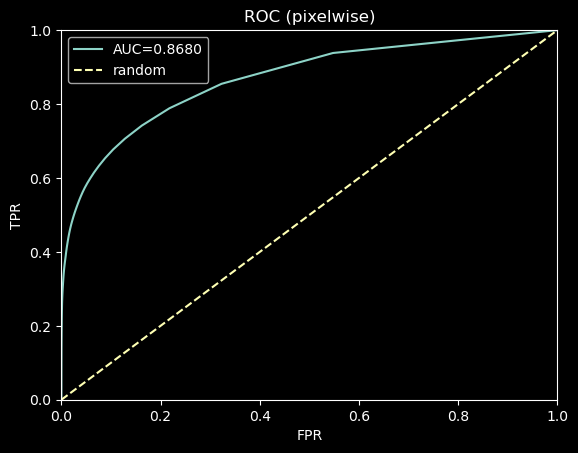

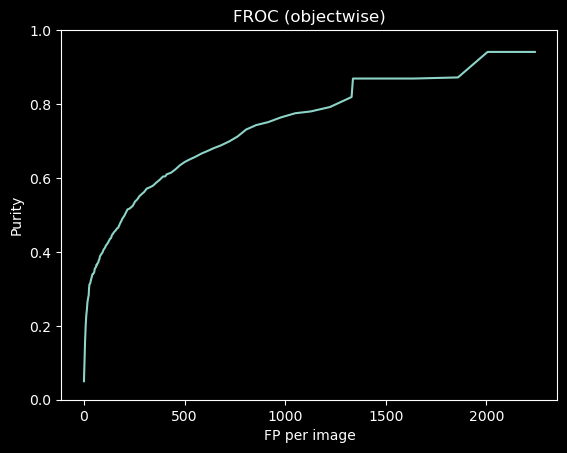

Pixel-wise Confusion Matrix
F1 Score: 0.2383, F2 Score: 0.2262
                 Predicted Negative  Predicted Positive
Actual Negative           812770176              622430
Actual Positive              786961              220433

Object-wise Confusion Matrix
F1 Score: 0.2367, F2 Score: 0.2768
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                1324
Actual Positive                 688                 312



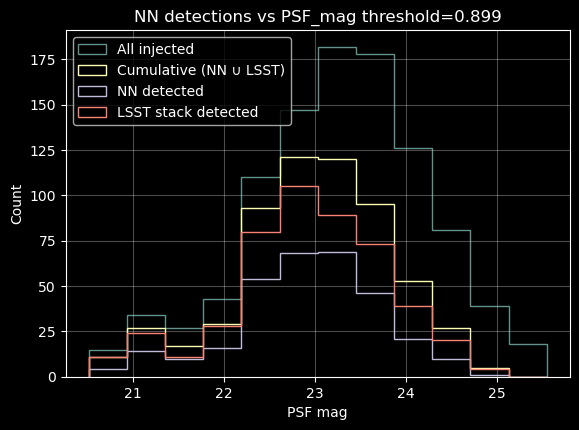

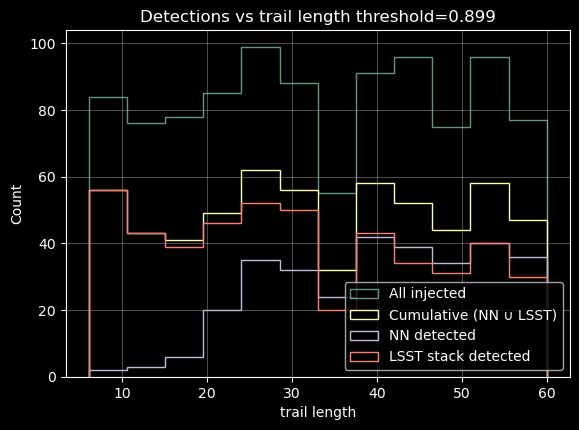

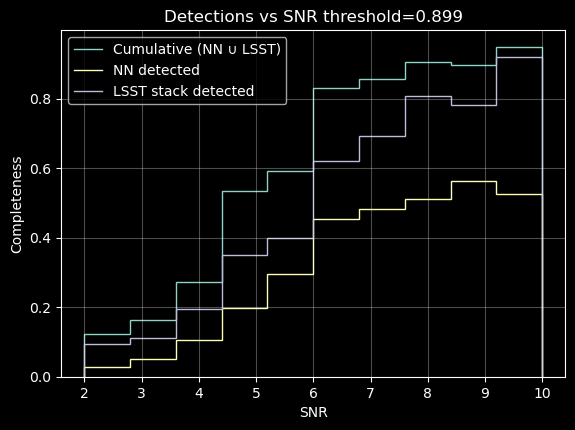

14990

In [8]:
cat_1 = calculate_model_metrics(test_catalog, p_1, gt_test, stack_fp=stack_fp)
del (p_1)
gc.collect()

## Idea 2

Loss biased toward LSST-missed examples. Weight the loss contribution per sample using lsst_detected: higher weight for LSST-missed, lower for LSST-detected. Optionally apply this weighting only in later epochs.

In [9]:
model_2 = load_model(SAVE_PATH+"Last/idea2.pt")
p_2 = predict_tiles_to_full(test_h5, test_loader, model_2, tile=128)
model_2.to('cpu')
del (model_2)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_2.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea2.pt
Predictions shape: (50, 4000, 4072)


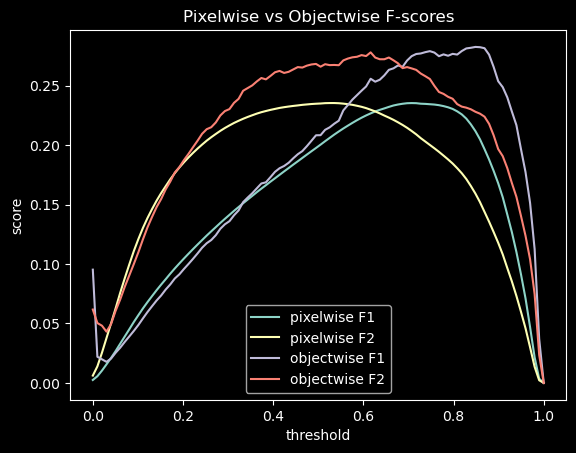

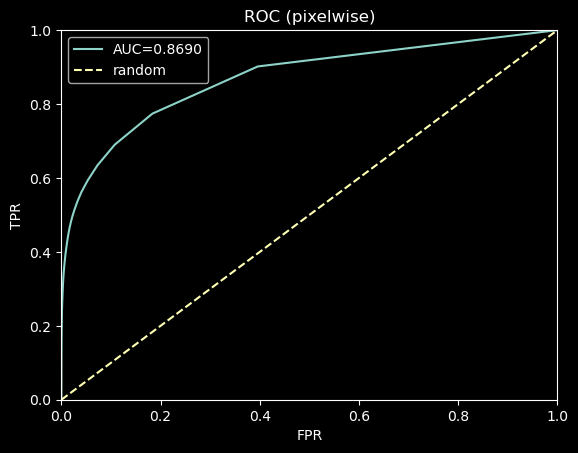

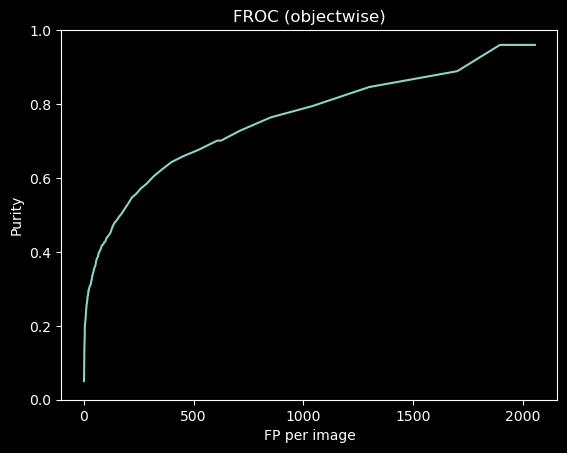

Pixel-wise Confusion Matrix
F1 Score: 0.2266, F2 Score: 0.2297
                 Predicted Negative  Predicted Positive
Actual Negative           812573096              819510
Actual Positive              773901              233493

Object-wise Confusion Matrix
F1 Score: 0.2574, F2 Score: 0.2787
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                 997
Actual Positive                 705                 295



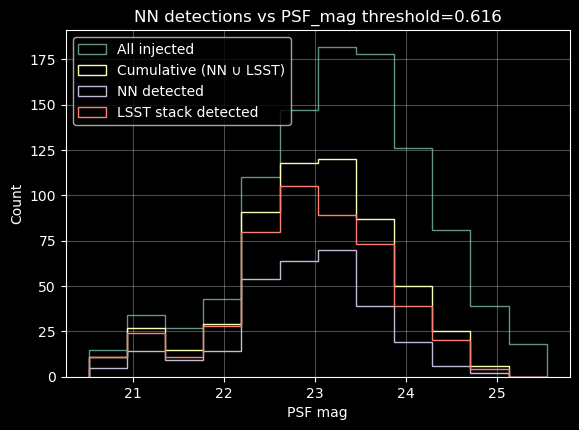

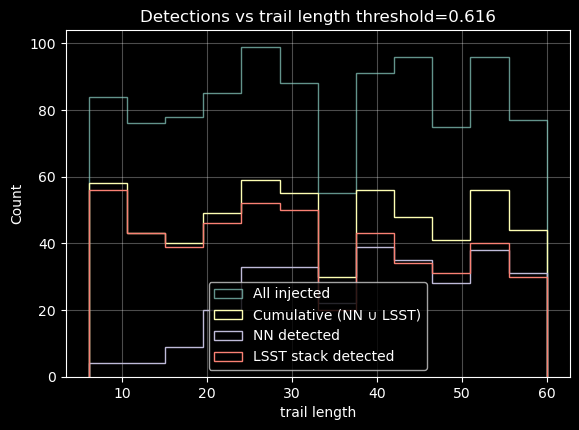

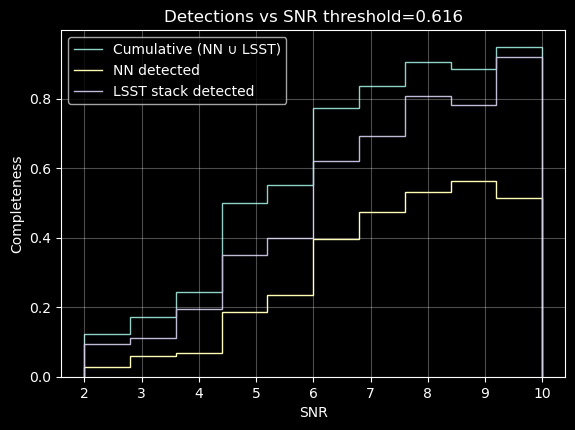

14261

In [10]:
cat_2 = calculate_model_metrics(test_catalog, p_2, gt_test, stack_fp=stack_fp)
del (p_2)
gc.collect()

## Idea 3

Two-phase loss schedule (BCE → Focal Tversky)

Phase 1: train with BCE (optionally BCE+Dice) for stability.

Phase 2: gradually blend in Focal Tversky: L = (1 - λ) * L_BCE + λ * L_FocalTversky, ramp λ from 0 to 1 over selected epochs. Optionally reduce learning rate at start of Phase 2.

In [11]:
model_3 = load_model(SAVE_PATH+"Last/idea3.pt")
p_3 = predict_tiles_to_full(test_h5, test_loader, model_3, tile=128)
model_3.to('cpu')
del (model_3)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_3.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea3.pt
Predictions shape: (50, 4000, 4072)


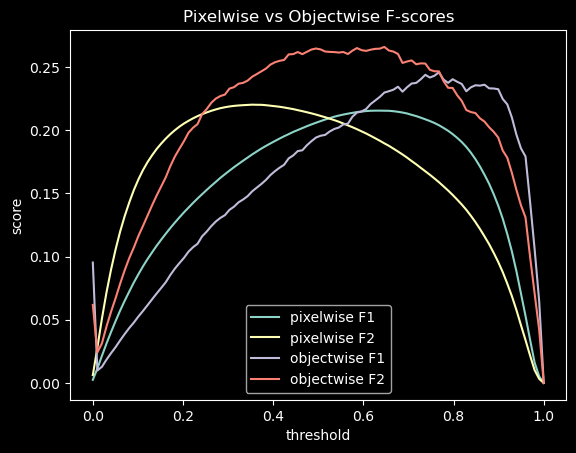

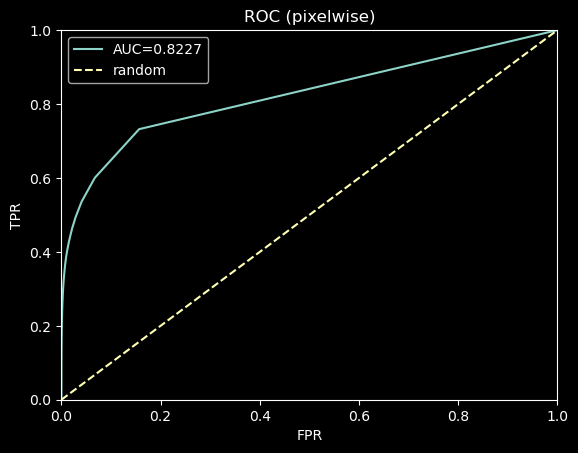

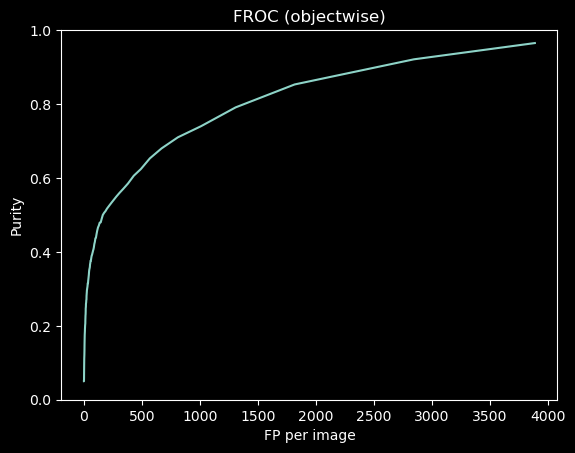

Pixel-wise Confusion Matrix
F1 Score: 0.2154, F2 Score: 0.1895
                 Predicted Negative  Predicted Positive
Actual Negative           812934740              457866
Actual Positive              830577              176817

Object-wise Confusion Matrix
F1 Score: 0.2337, F2 Score: 0.2680
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                1245
Actual Positive                 703                 297



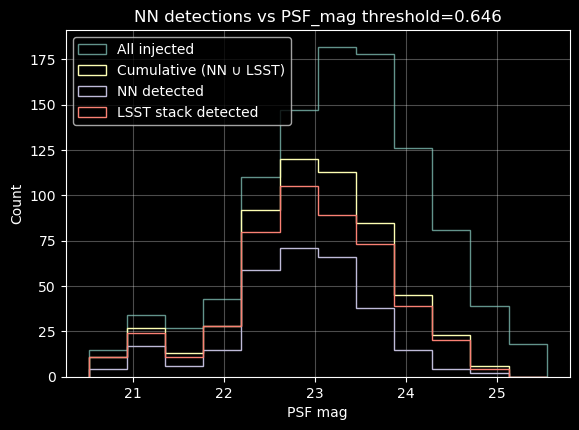

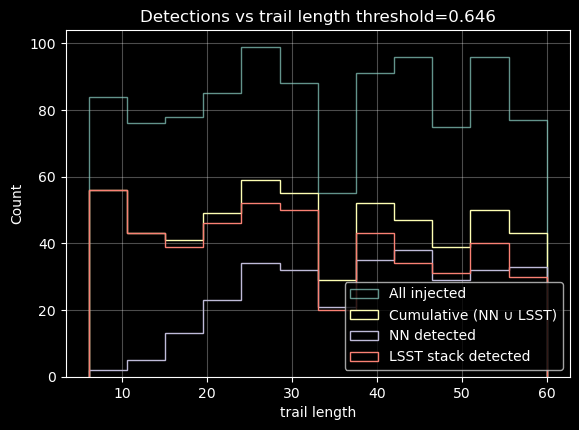

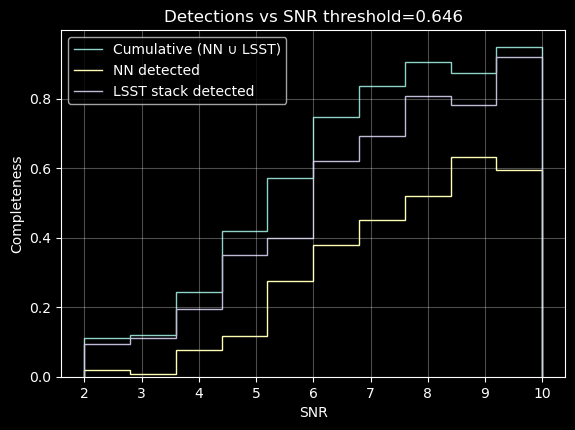

14256

In [12]:
cat_3 = calculate_model_metrics(test_catalog, p_3, gt_test, stack_fp=stack_fp)
del (p_3)
gc.collect()

## Idea 4

Keep NN output as continuous probability map p(y,x). Use a low pixel threshold t_low only to define connectivity: binary = (p >= t_low). Run connected-component labeling with pixel_gap to obtain candidate regions. For each candidate, compute a score from original probabilities: e.g. max(p) or mean(top-k p). An injected trail is detected if: (a) a candidate overlaps the truth mask, and (b) its score >= score_thr. t_low controls geometry/connectivity, score_thr controls detection confidence.

In [13]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(test_h5, test_loader, model_baseline, tile=128)
model_baseline.to('cpu')
gc.collect()
del model_baseline
torch.cuda.empty_cache()
p_4 = postprocess.two_threshold_prediction(p_baseline, t_low=0.1, pixel_gap=1)

Loaded model from: ../checkpoints/Experiments/Last/Baseline.pt


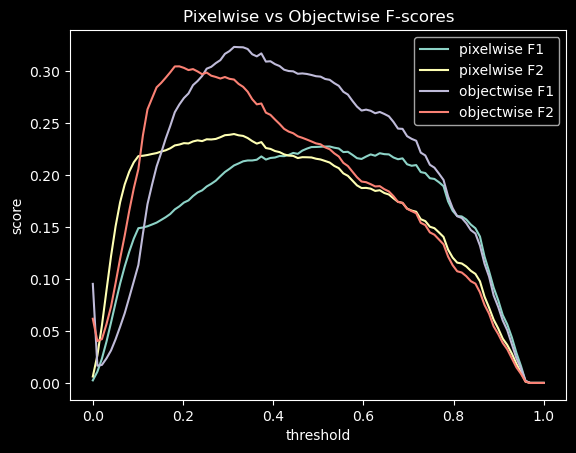

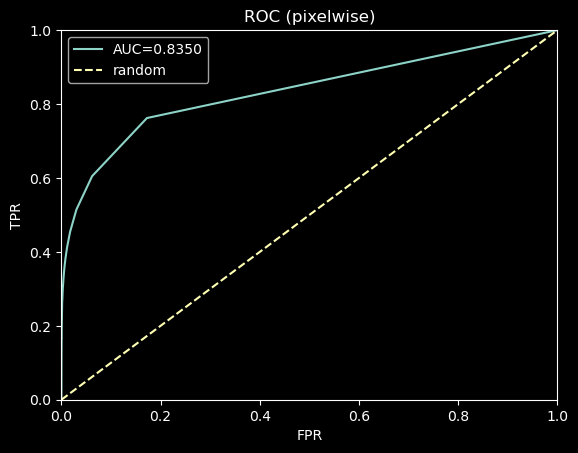

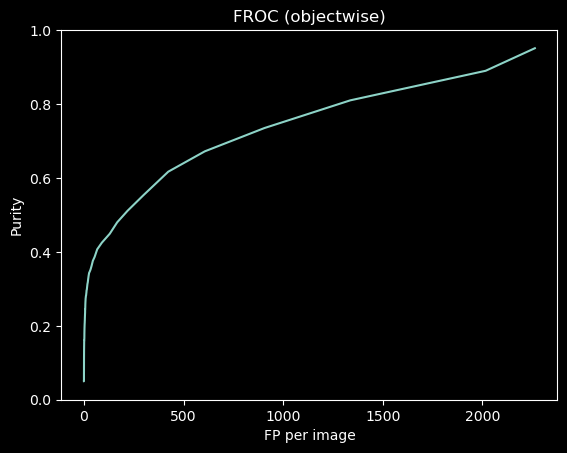

Pixel-wise Confusion Matrix
F1 Score: 0.1698, F2 Score: 0.2293
                 Predicted Negative  Predicted Positive
Actual Negative           811153781             2238825
Actual Positive              706150              301244

Object-wise Confusion Matrix
F1 Score: 0.2679, F2 Score: 0.3045
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                1166
Actual Positive                 665                 335



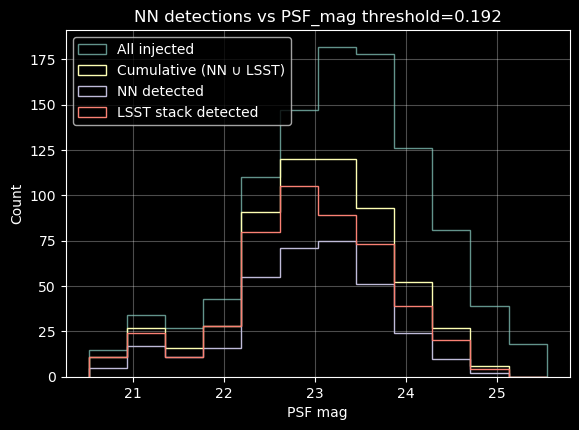

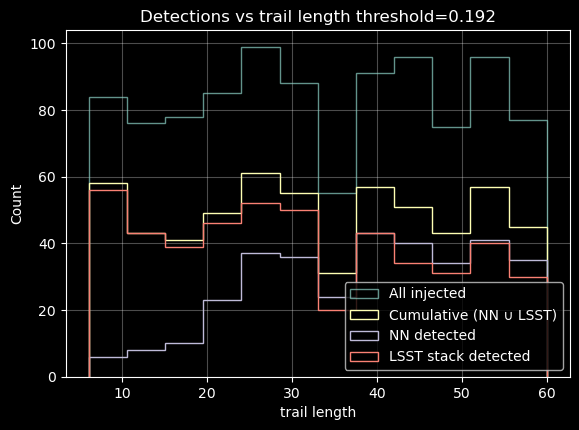

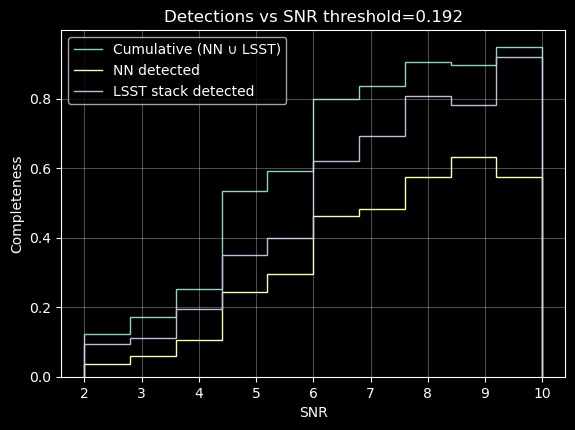

14253

In [14]:
cat_4 = calculate_model_metrics(test_catalog, p_4, gt_test, stack_fp=stack_fp)
del (p_4, p_baseline)
gc.collect()

## Idea 5

Line coherence bias (loss or auxiliary head)

Encourage elongated, coherent trail-like predictions.

Loss-based option: penalize isolated activations and compact blobs, encourage connectivity and elongation.

In [15]:
model_5 = load_model(SAVE_PATH+"Last/idea5.pt")
p_5 = predict_tiles_to_full(test_h5, test_loader, model_5, tile=128)
model_5.to('cpu')
del (model_5)
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_5.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea5.pt
Predictions shape: (50, 4000, 4072)


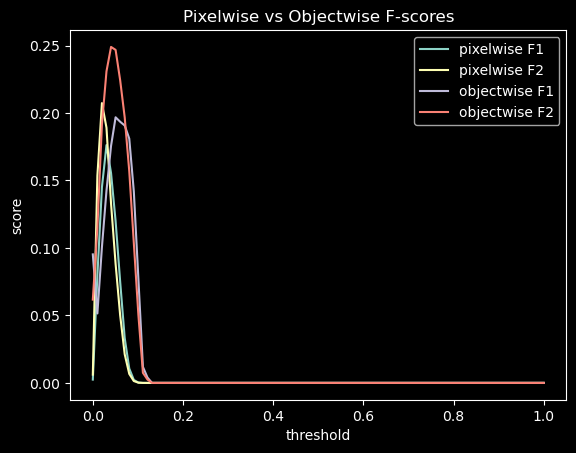

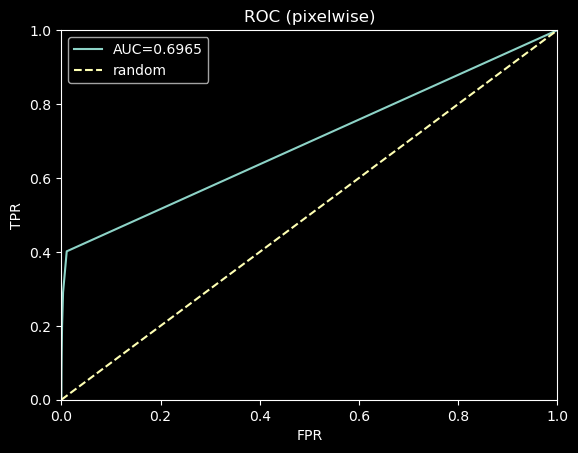

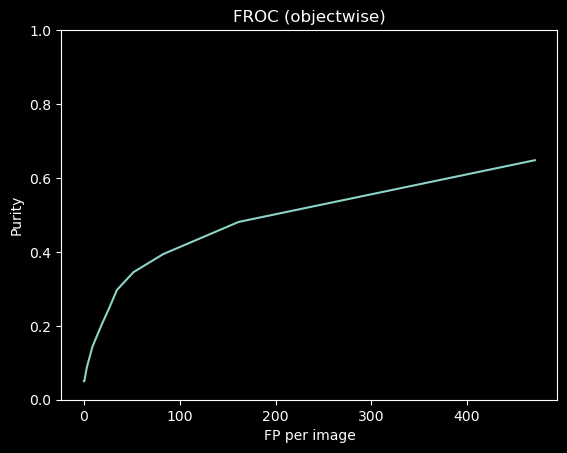

Pixel-wise Confusion Matrix
F1 Score: 0.1552, F2 Score: 0.1324
                 Predicted Negative  Predicted Positive
Actual Negative           812956380              436226
Actual Positive              885963              121431

Object-wise Confusion Matrix
F1 Score: 0.1776, F2 Score: 0.2505
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                2540
Actual Positive                 655                 345



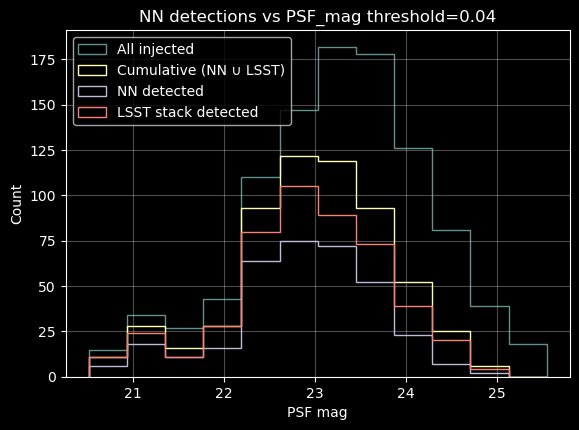

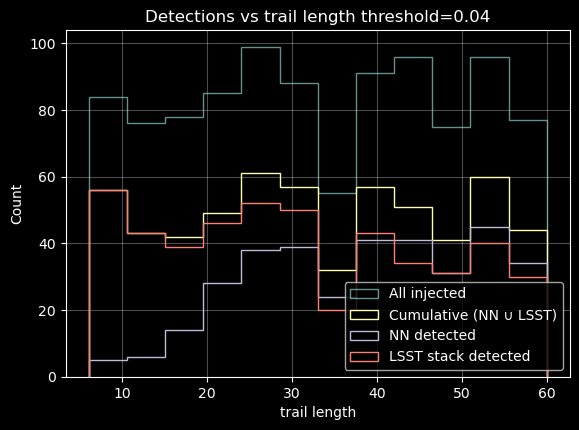

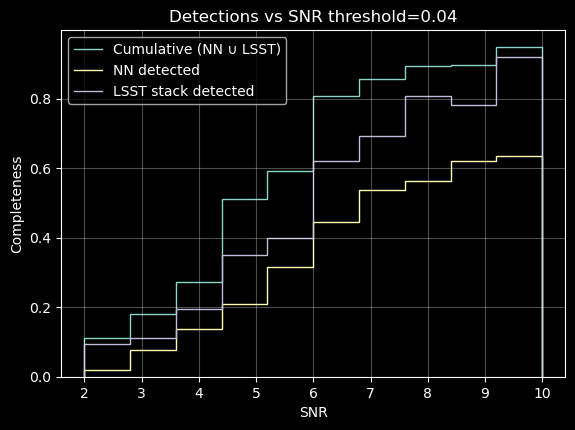

14268

In [16]:
cat_5 = calculate_model_metrics(test_catalog, p_5, gt_test, stack_fp=stack_fp)
del (p_5)
gc.collect()

## Idea 6
Line coherence bias (loss or auxiliary head)

Encourage elongated, coherent trail-like predictions.

Auxiliary-head option: add a head predicting local trail orientation or direction, trained from injection geometry or skeletonized truth masks.

In [17]:
import math
from typing import Dict, Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

def filter_tiles_by_panels(base_ds, panel_ids_set: set[int]) -> np.ndarray:
    out = []
    for ti, (pid, _r, _c) in enumerate(base_ds.indices):
        if int(pid) in panel_ids_set:
            out.append(ti)
    return np.asarray(out, dtype=np.int64)


class TileSubset(Dataset):
    def __init__(self, base, tile_indices: np.ndarray):
        self.base = base
        self.tile_indices = np.asarray(tile_indices, dtype=np.int64)

    def __len__(self) -> int:
        return int(self.tile_indices.size)

    def __getitem__(self, i: int):
        return self.base[int(self.tile_indices[int(i)])]


# -------------------------
# Orientation target builder (from GT mask)
# -------------------------
@torch.no_grad()
def orientation_target_from_mask(
    y: torch.Tensor,
    *,
    blur_ksize: int = 7,
    blur_sigma: float = 1.5,
    dilate: int = 3,
    grad_eps: float = 1e-3,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    y: float tensor [B,1,H,W] in {0,1} (or [B,1,h,w] after resize)
    Returns:
      ori_tgt:  [B,2,H,W] with (cos2, sin2)
      ori_mask: [B,1,H,W] boolean mask where loss is applied
    """
    assert y.ndim == 4 and y.size(1) == 1
    dev = y.device
    yt = y.float()

    # Optional dilation to include nearby pixels around the trail centerline.
    if dilate and dilate > 1:
        k = int(dilate)
        yt_d = F.max_pool2d(yt, kernel_size=k, stride=1, padding=k // 2)
        pos_mask = (yt_d > 0.5)
    else:
        pos_mask = (yt > 0.5)

    # Gaussian blur via separable 1D kernel (cheap, no torchvision dependency).
    if blur_ksize and blur_ksize >= 3:
        k = int(blur_ksize)
        if k % 2 == 0:
            k += 1
        r = k // 2
        xs = torch.arange(-r, r + 1, device=dev, dtype=torch.float32)
        g = torch.exp(-(xs ** 2) / (2.0 * float(blur_sigma) ** 2))
        g = (g / g.sum()).view(1, 1, 1, k)  # horizontal
        yt_blur = F.conv2d(yt, g, padding=(0, r))
        gT = g.transpose(-1, -2)  # vertical
        yt_blur = F.conv2d(yt_blur, gT, padding=(r, 0))
    else:
        yt_blur = yt

    # Sobel filters
    kx = torch.tensor([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]], device=dev, dtype=torch.float32).view(1, 1, 3, 3)
    ky = torch.tensor([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]], device=dev, dtype=torch.float32).view(1, 1, 3, 3)

    gx = F.conv2d(yt_blur, kx, padding=1)
    gy = F.conv2d(yt_blur, ky, padding=1)

    gmag = torch.sqrt(gx * gx + gy * gy)
    # valid where positive and gradient is meaningful
    ori_mask = pos_mask & (gmag > float(grad_eps))

    # Gradient direction is normal to line; tangent is +90deg
    theta = torch.atan2(gy, gx) + (math.pi / 2.0)

    # Use doubled-angle representation to remove 180° ambiguity:
    cos2 = torch.cos(2.0 * theta)
    sin2 = torch.sin(2.0 * theta)
    ori_tgt = torch.cat([cos2, sin2], dim=1)  # [B,2,H,W]
    return ori_tgt, ori_mask.float()


# -------------------------
# Model: UNetResSEASPP + aux orientation head
# (based on your current UNetResSEASPP code)
# -------------------------
class SEBlock(nn.Module):
    def __init__(self, c, r=8):
        super().__init__()
        self.fc1 = nn.Conv2d(c, c // r, 1)
        self.fc2 = nn.Conv2d(c // r, c, 1)

    def forward(self, x):
        s = F.adaptive_avg_pool2d(x, 1)
        s = F.silu(self.fc1(s), inplace=True)
        s = torch.sigmoid(self.fc2(s))
        return x * s


def _norm(c, groups=8):
    g = min(groups, c) if c % groups == 0 else 1
    return nn.GroupNorm(g, c)


class ResBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, act=nn.SiLU, se=True):
        super().__init__()
        p = k // 2
        self.proj = nn.Identity() if c_in == c_out else nn.Conv2d(c_in, c_out, 1)
        self.bn1 = _norm(c_in)
        self.c1 = nn.Conv2d(c_in, c_out, k, padding=p, bias=False)
        self.bn2 = _norm(c_out)
        self.c2 = nn.Conv2d(c_out, c_out, k, padding=p, bias=False)
        self.act = act()
        self.se = SEBlock(c_out) if se else nn.Identity()

    def forward(self, x):
        h = self.act(self.bn1(x))
        h = self.c1(h)
        h = self.act(self.bn2(h))
        h = self.c2(h)
        h = self.se(h)
        return h + self.proj(x)


class Down(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.rb = ResBlock(c_in, c_out)

    def forward(self, x):
        return self.rb(self.pool(x))


class Up(nn.Module):
    def __init__(self, c_in, c_skip, c_out):
        super().__init__()
        self.up = nn.ConvTranspose2d(c_in, c_in, 2, stride=2)
        self.rb1 = ResBlock(c_in + c_skip, c_out)
        self.rb2 = ResBlock(c_out, c_out)

    def forward(self, x, skip):
        x = self.up(x)
        dh = skip.size(-2) - x.size(-2)
        dw = skip.size(-1) - x.size(-1)
        if dh or dw:
            x = F.pad(x, (0, max(0, dw), 0, max(0, dh)))
        x = torch.cat([x, skip], 1)
        x = self.rb1(x)
        x = self.rb2(x)
        return x


class ASPP(nn.Module):
    def __init__(self, c, r=(1, 6, 12, 18)):
        super().__init__()
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(c, c // 4, 3, padding=d, dilation=d, bias=False),
                nn.BatchNorm2d(c // 4),
                nn.SiLU(True),
            )
            for d in r
        ])
        self.project = nn.Conv2d(c, c, 1)

    def forward(self, x):
        return self.project(torch.cat([b(x) for b in self.blocks], 1))


class UNetResSEASPP_AuxOri(nn.Module):
    """
    Returns (seg_logits, ori_pred) where:
      seg_logits: [B,1,H,W]
      ori_pred:   [B,2,H,W] (tanh range)
    """
    def __init__(self, in_ch=1, widths=(32, 64, 128, 256, 512)):
        super().__init__()
        w = widths
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, w[0], 3, padding=1, bias=False),
            nn.BatchNorm2d(w[0]),
            nn.SiLU(True),
            ResBlock(w[0], w[0]),
        )
        self.d1 = Down(w[0], w[1])
        self.d2 = Down(w[1], w[2])
        self.d3 = Down(w[2], w[3])
        self.d4 = Down(w[3], w[4])

        self.aspp = ASPP(w[4])

        self.u1 = Up(w[4], w[3], w[3])
        self.u2 = Up(w[3], w[2], w[2])
        self.u3 = Up(w[2], w[1], w[1])
        self.u4 = Up(w[1], w[0], w[0])

        self.head = nn.Conv2d(w[0], 1, 1)     # segmentation
        self.aux_head = nn.Conv2d(w[0], 2, 1) # orientation (cos2, sin2)

    def forward(self, x):
        s0 = self.stem(x)
        s1 = self.d1(s0)
        s2 = self.d2(s1)
        s3 = self.d3(s2)
        b = self.d4(s3)
        b = self.aspp(b)

        x = self.u1(b, s3)
        x = self.u2(x, s2)
        x = self.u3(x, s1)
        x = self.u4(x, s0)

        seg = self.head(x)
        ori = torch.tanh(self.aux_head(x))
        return seg, ori

class SegOnlyWrapper(nn.Module):
    """Expose only segmentation logits for code paths expecting model(x)->logits Tensor."""
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        if isinstance(out, (tuple, list)):
            return out[0]
        return out

def load_model_idea6(ckpt_path):
    ckpt = torch.load(ckpt_path)
    model = UNetResSEASPP_AuxOri(in_ch=1)
    model.load_state_dict(ckpt["state"])
    model.eval()
    print("Loaded model from:", ckpt_path)
    return model

In [18]:
model_6 = load_model_idea6(SAVE_PATH+"Last/idea6.pt")
model_6 = SegOnlyWrapper(model_6)
p_6 = predict_tiles_to_full(test_h5, test_loader, model_6, tile=128)
model_6.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_6.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea6.pt
Predictions shape: (50, 4000, 4072)


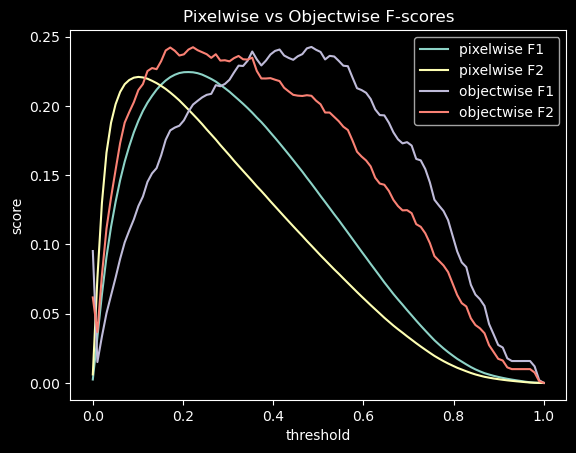

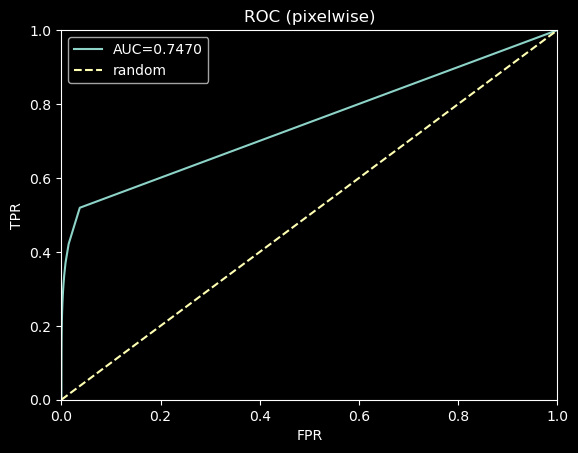

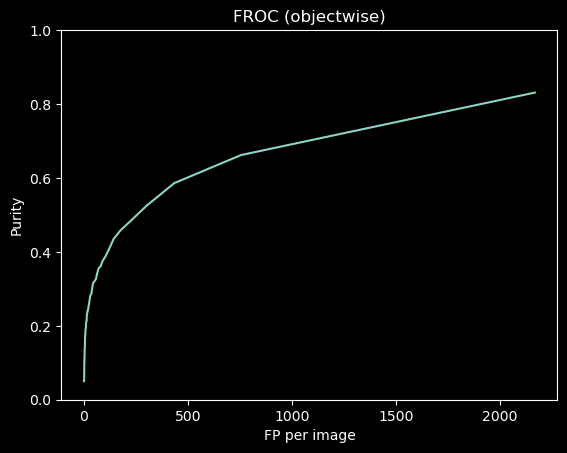

Pixel-wise Confusion Matrix
F1 Score: 0.2243, F2 Score: 0.1939
                 Predicted Negative  Predicted Positive
Actual Negative           812981399              411207
Actual Positive              828207              179187

Object-wise Confusion Matrix
F1 Score: 0.2032, F2 Score: 0.2437
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                1485
Actual Positive                 719                 281



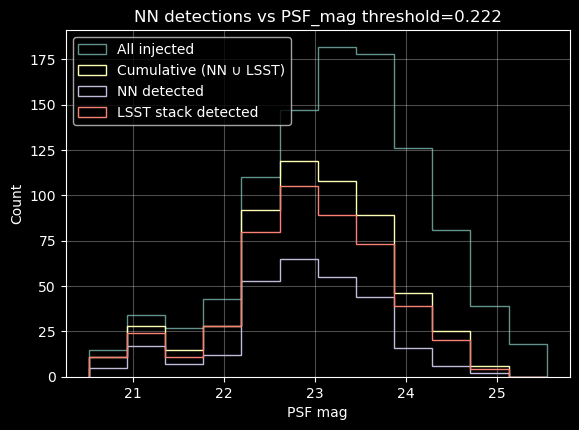

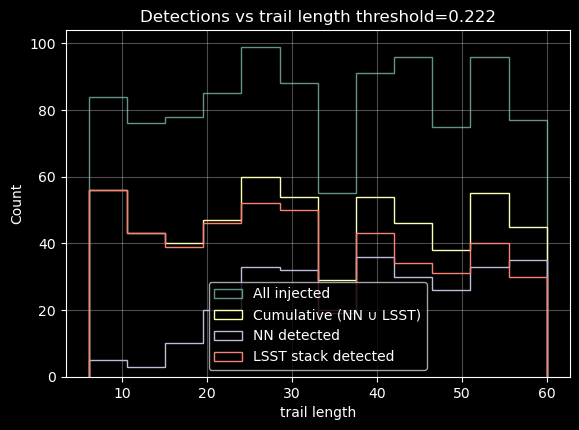

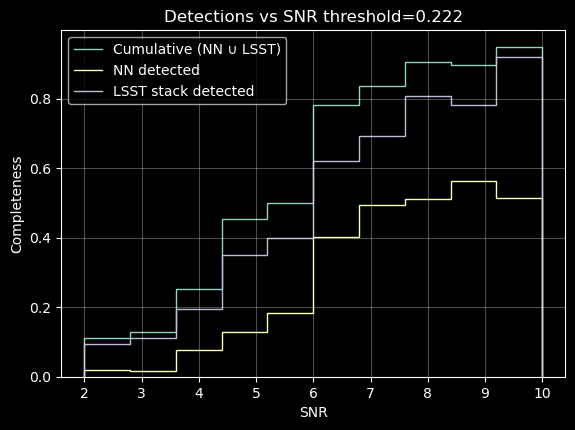

14258

In [19]:
cat_6 = calculate_model_metrics(test_catalog, p_6, gt_test, stack_fp=stack_fp)
del (p_6)
gc.collect()

## Idea 7

Create a loss that ignores any false positives detected by the stack. Do not punish any FP detected by the stacl

In [20]:
model_7 = load_model(SAVE_PATH+"Last/idea7.pt")
p_7 = predict_tiles_to_full(test_h5, test_loader, model_7, tile=128)
model_7.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_7.shape)

Loaded model from: ../checkpoints/Experiments/Last/idea7.pt
Predictions shape: (50, 4000, 4072)


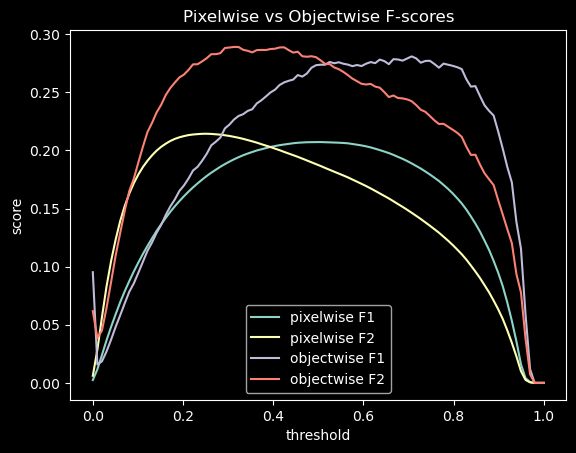

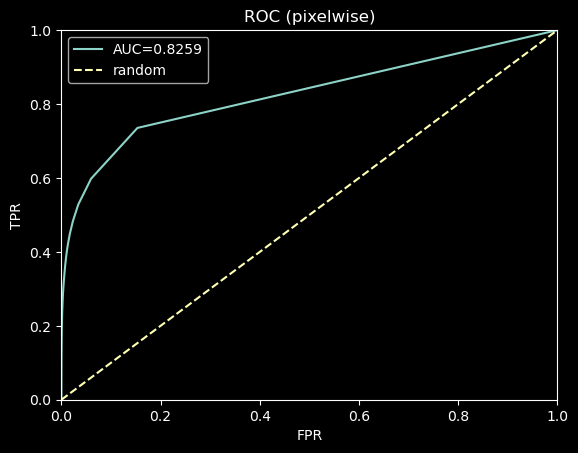

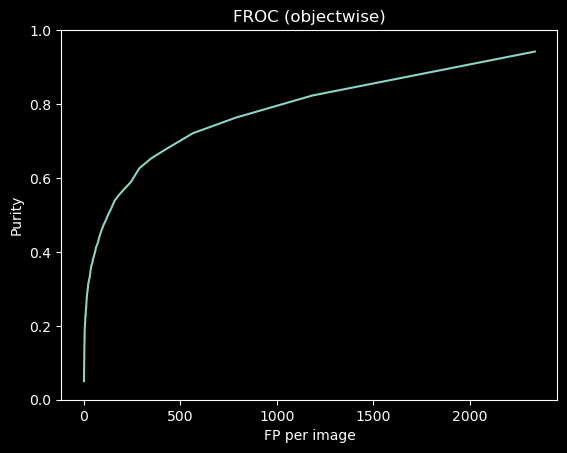

Pixel-wise Confusion Matrix
F1 Score: 0.1923, F2 Score: 0.2116
                 Predicted Negative  Predicted Positive
Actual Negative           812252149             1140457
Actual Positive              778875              228519

Object-wise Confusion Matrix
F1 Score: 0.2277, F2 Score: 0.2897
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                1756
Actual Positive                 646                 354



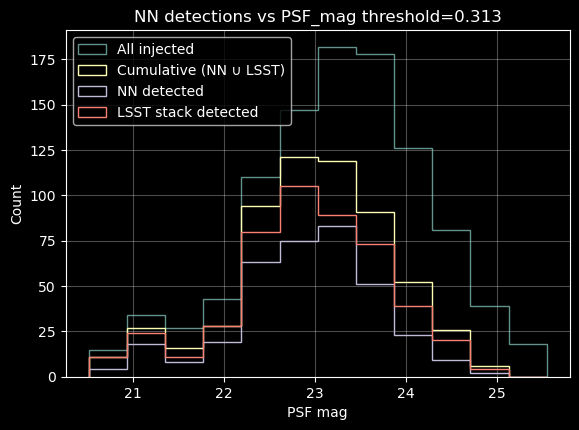

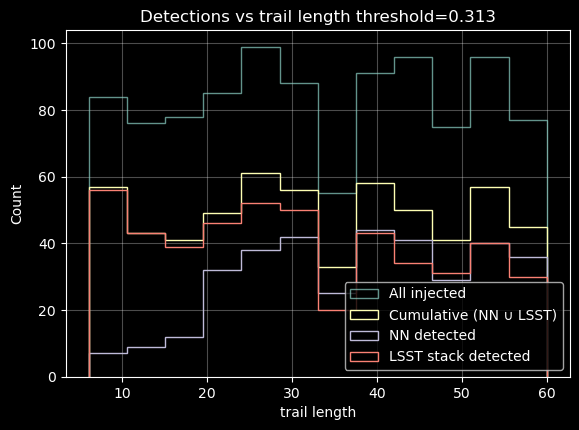

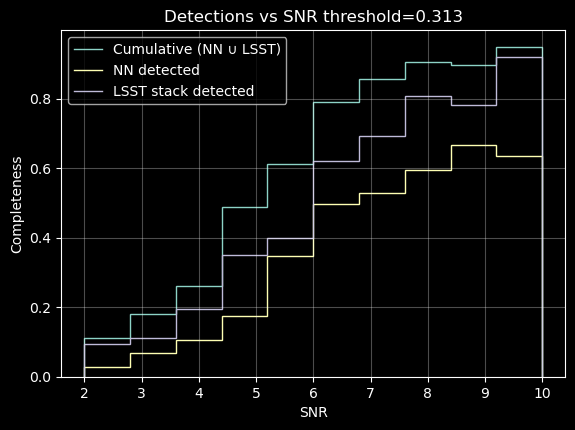

In [21]:
cat_7 = calculate_model_metrics(test_catalog, p_7, gt_test, stack_fp=stack_fp)
#del (p_6)
#gc.collect()

In [22]:
p_7_tt = postprocess.two_threshold_prediction(p_7, t_low=0.07, pixel_gap=1)

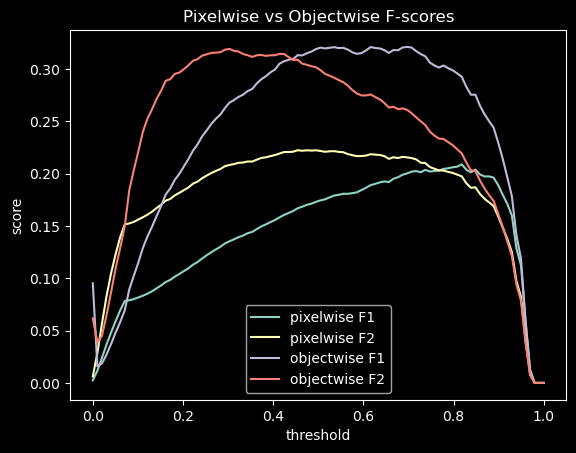

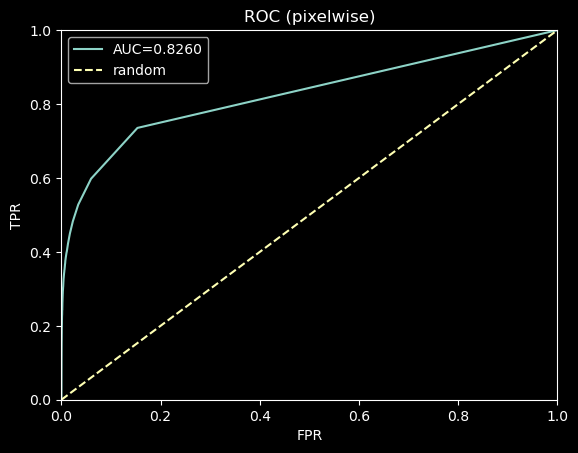

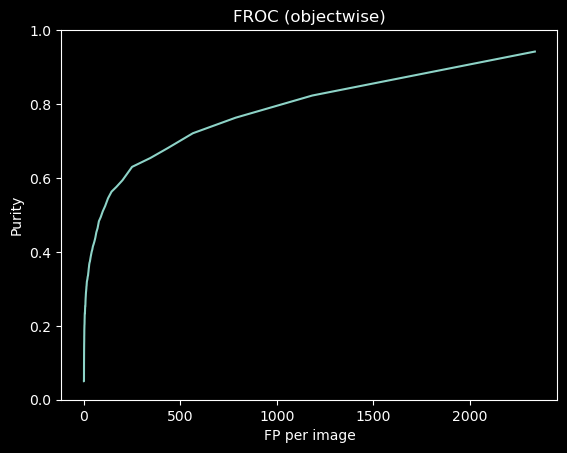

Pixel-wise Confusion Matrix
F1 Score: 0.1354, F2 Score: 0.2084
                 Predicted Negative  Predicted Positive
Actual Negative           809890455             3502151
Actual Positive              679888              327506

Object-wise Confusion Matrix
F1 Score: 0.2679, F2 Score: 0.3193
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>                1366
Actual Positive                 634                 366



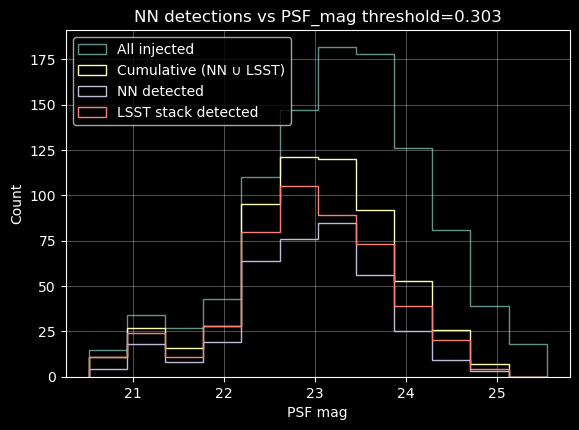

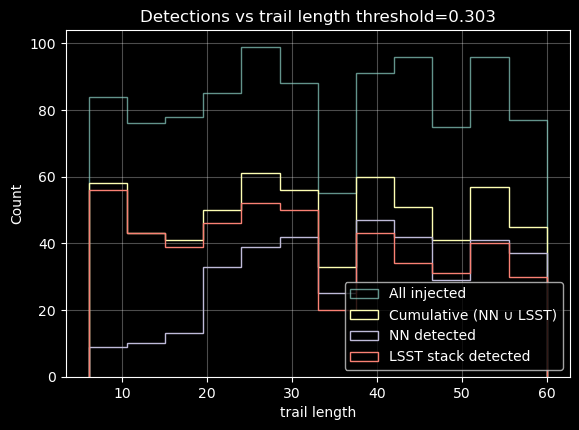

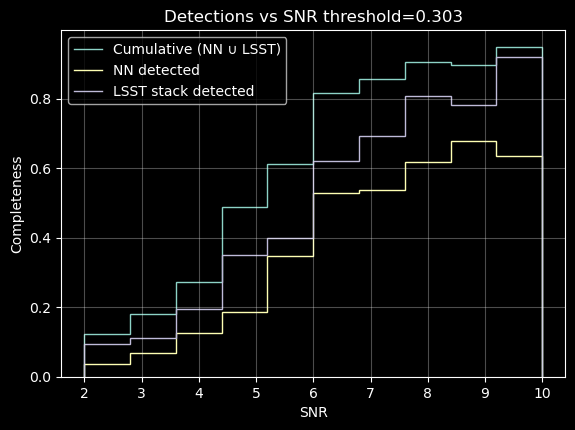

In [23]:
cat_7_tt = calculate_model_metrics(test_catalog, p_7_tt, gt_test, stack_fp=stack_fp)
#del (p_6)
#gc.collect()